In [467]:
import pandas as pd
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None

from typing import Dict, List, Tuple, Text
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.model_selection import GridSearchCV
from tpot import TPOTRegressor


from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt

# Cleaning 

In [4]:
# # Read data
df = pd.read_csv('cleaned_csv') #From Louis Combine
df = df.set_index('sofifa_id')
#Drop for anylsis only
#later should be use sofifa_id to merge together
drop_col = ['player_url','long_name', 'short_name', 'dob', 'real_face', 'release_clause_eur', 'team_position',
           'player_tags', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position',
           'nation_jersey_number', 'player_traits']
df = df.drop(columns = drop_col)
#drop for ls	st	rs	lw	lf	cf	rf	rw	lam	cam	ram	lm	lcm	cm	rcm	rm	lwb	ldm	cdm	rdm	rwb	lb	lcb	cb	rcb	rb
exclude_col = df.columns[62:-1]
print(exclude_col)
df = df.drop(columns = exclude_col)
#Assumption: nationality, club, preferred_foot and body_type would not affect the potential score
df = df.drop(columns = ['nationality', 'club', 'preferred_foot', 'body_type'])
display(df)

Index(['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram',
       'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb',
       'lcb', 'cb', 'rcb', 'rb'],
      dtype='object')


,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,player_positions,international_reputation,weak_foot,...,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year
sofifa_id,,,,,,,,,,,,,,,,,,,,,
158023,28,170,72,94,95,111000000,550000,"RW, CF",5,4,...,0.0,25,25,22,6,11,15,14,8,2016
20801,30,185,80,93,93,85500000,475000,"LW, LM",5,4,...,0.0,22,31,23,7,11,15,14,11,2016
9014,31,180,80,90,90,56000000,250000,"RM, LM, RW",5,2,...,0.0,29,26,26,10,8,11,5,15,2016
167495,29,193,92,90,90,58000000,250000,GK,5,4,...,0.0,25,25,25,88,89,91,90,86,2016
176580,28,182,85,90,90,69000000,300000,ST,5,4,...,0.0,30,45,38,27,25,31,33,37,2016
183277,24,173,74,89,91,74000000,240000,LM,4,4,...,0.0,25,27,22,11,12,6,8,8,2016
41236,33,195,95,89,89,40500000,220000,ST,5,4,...,0.0,25,41,27,13,15,10,9,12,2016
190871,23,174,68,88,93,71500000,230000,LW,5,5,...,0.0,21,24,33,9,9,15,15,11,2016
164240,30,183,79,88,88,38000000,200000,CB,4,3,...,0.0,92,92,90,9,12,5,9,10,2016


In [7]:
# Position
def postition_grouping(value) -> Text:
    forward = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw']
    mid = ['lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'ldm', 'cdm', 'rdm']
    back = ['lwb', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
    keeper = ['gk']
    
    position_dict = {}
    position_dict['forward'] = forward
    position_dict['mid'] = mid
    position_dict['back'] = back
    position_dict['keeper'] = keeper
    
    value_list = value.replace(' ','').split(',')
    
    for v in value_list:
        for position, items in position_dict.items():
            if v.lower() in items:
                return (position)
    print('Error')
df['position'] = df['player_positions'].apply(lambda x: postition_grouping(x))
df = df.drop(columns = 'player_positions')

In [9]:
#work_rate ranking 
def work_rate_convert(value):
    value = value.split('/')
    prefix = value[0]
    suffix = value[1]
    
    group = {}
    group['Low'] = 0
    group['Medium'] = 3
    group['High'] = 6
    
    level = {}
    level['Low'] = 0
    level['Medium'] = 1
    level['High'] = 2
    
    group_score = group[prefix]
    level_score = level[suffix]
    rank = group_score + level_score
    return rank
df['work_rate_rank'] = df['work_rate'].apply(lambda x:work_rate_convert(x))
#pd.unique(df['work_rate'])
df = df.drop(columns = ['work_rate'])

In [11]:
#Separate for different position analysis
df_dict = {}
df_dict['overall'] = df.copy()
df_dict['forward'] = df[df['position'] == 'forward']
df_dict['mid'] = df[df['position'] == 'mid']
df_dict['back'] = df[df['position'] == 'back']
df_dict['keeper'] = df[df['position'] == 'keeper']

In [595]:
#Set up the y
overall_df = df_dict['overall']
player_id_list = list(pd.unique(overall_df.index))
player_id_list.sort(reverse = True)

new_df = pd.DataFrame()
n = 0
for player_id in player_id_list:
    #Filter len > 1
    group_df = overall_df[overall_df.index == player_id]
    if len(group_df) <= 1:
        n += 1 #no.of player filter out
        continue
    #Order by year
    group_df = group_df.sort_values('year', ascending = True)
    group_df = group_df.reset_index()
    #Lag 1 df
    lag_1_df = group_df.shift(-1)[['value_eur', 'overall']]
    lag_1_df = lag_1_df.rename(columns = {'value_eur': 'y_value_eur', 'overall': 'y_overall'})
    combine_df = group_df.join(lag_1_df)
    combine_df = combine_df.iloc[0:-1] #Delete the 2020 data
    combine_df = combine_df.set_index('sofifa_id')
    new_df = new_df.append(combine_df)
    

In [596]:
#Position to be categories
def position_convert(value):
    if value == 'forward':
        return 0
    elif value == 'mid':
        return 1
    elif value == 'back':
        return 2
    elif value == 'keeper':
        return 3

#new_df.to_csv('pre_model_df.csv')
new_df['position'] = new_df['position'].apply(lambda x:position_convert(x))

In [597]:
new_df

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,position,work_rate_rank,y_value_eur,y_overall
sofifa_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
246063,18,185,75,54,68,130000,1000,1,3,2,64.0,37.0,48.0,52.0,52.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,43,30,53,52,43,49,45,34,55,53,60,67,60,53,59,56,59,52,66,32,56,45,34,46,44,43.0,48,59,58,14,8,14,11,11,2019,1,4,170000.0,55.0
246057,21,178,70,65,74,0,0,1,3,2,71.0,58.0,62.0,60.0,63.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,62,56,62,69,48,58,32,54,67,56,70,71,74,66,72,64,66,69,58,62,67,65,52,55,49,57.0,64,63,59,7,10,9,14,13,2019,1,4,775000.0,65.0
246051,17,182,73,49,61,50000,1000,1,3,2,73.0,40.0,43.0,49.0,36.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,41,42,40,40,40,48,42,36,42,50,75,72,52,42,58,40,48,45,50,38,40,36,41,55,35,49.0,30,40,40,10,8,14,11,11,2019,1,7,50000.0,49.0
246049,20,172,70,61,73,450000,3000,1,2,2,68.0,60.0,43.0,56.0,18.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,30,65,59,53,49,55,30,34,45,55,69,68,54,60,79,60,65,70,59,53,31,19,59,41,55,58.0,11,12,17,6,7,12,6,6,2019,0,7,825000.0,64.0
246048,18,177,75,54,70,130000,1000,1,3,2,61.0,30.0,30.0,33.0,54.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,24,23,48,34,29,21,31,29,28,38,62,61,51,45,69,40,76,68,61,33,49,58,28,29,36,43.0,50,57,52,12,5,9,15,8,2019,2,1,750000.0,63.0
246045,17,177,70,61,78,500000,2000,1,3,2,72.0,59.0,57.0,61.0,28.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,60,63,43,62,50,60,51,42,51,62,74,70,63,55,68,64,53,58,47,52,31,18,61,53,47,59.0,26,29,31,8,9,15,8,9,2019,0,7,3700000.0,70.0
246044,18,180,75,62,78,625000,1000,1,3,3,65.0,61.0,54.0,62.0,27.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,51,63,59,58,56,63,55,43,52,62,66,64,60,59,66,59,61,33,54,62,49,23,61,53,61,59.0,21,25,22,13,10,8,12,8,2019,0,4,1600000.0,67.0
246033,19,179,78,56,71,180000,1000,1,3,2,56.0,41.0,55.0,58.0,52.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,42,38,52,64,34,59,39,40,61,56,58,55,55,51,64,53,58,49,60,37,60,50,32,54,47,49.0,52,51,59,6,13,13,10,10,2019,1,4,1600000.0,67.0
246032,21,192,85,58,65,130000,1000,1,3,1,0.0,0.0,0.0,0.0,0.0,0.0,52.0,57.0,59.0,67.0,26.0,54.0,10,8,11,28,9,10,10,11,17,17,30,23,33,51,24,15,34,27,60,7,28,7,6,36,18,23.0,5,14,10,52,57,59,54,67,2019,3,4,140000.0,58.0


# Value_eur Prediction Model (Multi-linear Regrssion)

In [350]:
#MAPE
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred)) / (y_true + 1)) * 100


In [330]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [598]:
#1. Wage_df
wage_df = new_df.drop(columns = ['y_overall'])
df_x = wage_df.drop(columns = ['y_value_eur'])
df_y = wage_df[['y_value_eur']]

#Column Transform
df_x[['value_eur', 'wage_eur']] = preprocessing.MinMaxScaler().fit_transform(df_x[['value_eur', 'wage_eur']])


In [599]:
#Dimension Reduction by stepwise for mlr
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [600]:
#Dimension_reduction
mlr_features_result = stepwise_selection(df_x, df_y)

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  mentality_vision               with p-value 0.0
Add  value_eur                      with p-value 0.0
Add  age                            with p-value 0.0
Add  overall                        with p-value 1.01239e-184
Add  international_reputation       with p-value 9.84796e-33
Add  year                           with p-value 1.33013e-35
Add  wage_eur                       with p-value 1.20231e-22
Add  movement_reactions             with p-value 4.24832e-06
Add  height_cm                      with p-value 3.72331e-06
Add  potential                      with p-value 7.721e-06
Add  defending                      with p-value 0.000526687
Add  defending_standing_tackle      with p-value 0.000521476
Add  skill_dribbling                with p-value 1.23224e-06
Drop mentality_vision               with p-value 0.160382


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  mentality_composure            with p-value 0.000199102
Add  skill_moves                    with p-value 0.00709629


In [601]:
df_x_filter = df_x[mlr_features_result]

In [340]:
# # #Scale Data
# x_min_max_scaler = preprocessing.MinMaxScaler().fit(X_train)
# X_train_minmax = x_min_max_scaler.transform(X_train)
# X_test_minmax = x_min_max_scaler.transform(X_test)

# y_min_max_scaler = preprocessing.MinMaxScaler().fit(y_train)
# y_train_minmax = y_min_max_scaler.transform(y_train)
# y_test_minmax = y_min_max_scaler.transform(y_test)

In [602]:
X_train, X_test, y_train, y_test = train_test_split(df_x_filter, df_y, test_size=0.2, random_state=1)
#Tranditional Linear Model
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_predicted_y = mlr.predict(X_test)

In [603]:
mlr_predicted_y = np.where(mlr_predicted_y <=0, 0, mlr_predicted_y)

In [604]:
#Wage MLR Error
value_eur_mlr_mape = mean_absolute_percentage_error(mlr_predicted_y, y_test)
print('value_eur_mlr_mape:', value_eur_mlr_mape)
value_eur_mlr_rmse = sqrt(mean_squared_error(y_test, mlr_predicted_y))
print('value_eur_mlr_rmse:', value_eur_mlr_rmse)

value_eur_mlr_mape: y_value_eur    2.171257e+06
dtype: float64
value_eur_mlr_rmse: 2285687.289133613


In [605]:
wage_df['value_eur'].describe()

count    5.210700e+04
mean     2.585488e+06
std      5.607298e+06
min      0.000000e+00
25%      3.750000e+05
50%      8.000000e+05
75%      2.300000e+06
max      1.230000e+08
Name: value_eur, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1a41e6dcf8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a41e6d0b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a41e6d5c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a41de3400>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a41de3780>],
 'means': []}

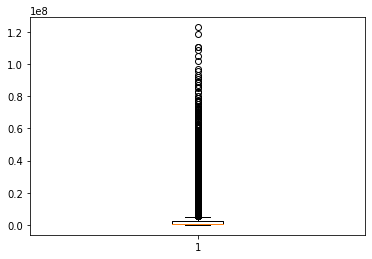

In [606]:
plt.boxplot(wage_df['value_eur'])

### Filter outlier Version

In [607]:
#Filter out the too expensive player
#1. Wage_df
wage_df = new_df.drop(columns = ['y_overall'])

mean_value = np.mean(wage_df['value_eur'])
sd_value = np.std(wage_df['value_eur'])
wage_df = wage_df[(wage_df['value_eur'] >0) & (wage_df['value_eur'] <= mean_value + 2 * sd_value)]
df_x = wage_df.drop(columns = ['y_value_eur'])
df_y = wage_df[['y_value_eur']]

# #Column Transform
df_x[['value_eur', 'wage_eur']] = preprocessing.MinMaxScaler().fit_transform(df_x[['value_eur', 'wage_eur']])
df_x_filter = df_x[mlr_features_result]

In [608]:
X_train, X_test, y_train, y_test = train_test_split(df_x_filter, df_y, test_size=0.2, random_state=1)
#Tranditional Linear Model
mlr = LinearRegression()
mlr.fit(X_train, y_train)
filter_mlr_predicted_y = mlr.predict(X_test)


In [611]:
#Wage MLR Error
filter_value_mlr_mape = mean_absolute_percentage_error(filter_mlr_predicted_y, y_test)
print('value_mlr_mape:', filter_value_mlr_mape)
filter_value_mlr_rmse = sqrt(mean_squared_error(y_test, filter_mlr_predicted_y))
print('value_mlr_rmse:', filter_value_mlr_rmse)

value_mlr_mape: y_value_eur    32.363165
dtype: float64
value_mlr_rmse: 1789941.5995008876


# Wage Prediction - XGboost

In [613]:
#1. Wage_df
wage_df = new_df.drop(columns = ['y_overall'])
df_x = wage_df.drop(columns = ['y_value_eur'])
df_y = wage_df[['y_value_eur']]

#Column Transform
df_x[['value_eur', 'wage_eur']] = preprocessing.MinMaxScaler().fit_transform(df_x[['value_eur', 'wage_eur']])


In [614]:
#XGBoost
wage_xgboost = xgboost.XGBRegressor(random_state = 1)
wage_xgboost.fit(df_x, df_y)

[21:12:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [615]:
#Feature Selection
feature_value_list = OrderedDict(wage_xgboost.get_booster().get_fscore().items())
xgboost_filter = []
for feature, value in feature_value_list.items():
    if value >= 10:
        xgboost_filter.append(feature)
xgboost_filter

['value_eur',
 'potential',
 'dribbling',
 'overall',
 'movement_acceleration',
 'mentality_positioning',
 'age',
 'year',
 'skill_ball_control',
 'defending',
 'skill_dribbling',
 'attacking_finishing',
 'defending_marking',
 'wage_eur',
 'attacking_volleys',
 'shooting',
 'mentality_composure',
 'passing']

In [616]:
df_x_filter = df_x[xgboost_filter]
X_train, X_test, y_train, y_test = train_test_split(df_x_filter, df_y, test_size=0.2, random_state=1)

In [617]:
wage_xgboost = xgboost.XGBRegressor(random_state = 1)
wage_xgboost.fit(df_x_filter, df_y)

[21:12:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [618]:
xgboost_predicted_y = wage_xgboost.predict(X_test)
#Wage XGboost Error
value_xgboost_mape = mean_absolute_percentage_error(xgboost_predicted_y, y_test.values)
print('value_mlr_mape:', value_xgboost_mape)
value_xgboost_rmse = sqrt(mean_squared_error(y_test, xgboost_predicted_y))
print('value_mlr_rmse:', value_xgboost_rmse)

value_mlr_mape: 392.8634837084147
value_mlr_rmse: 2082388.9375095852


### Filter outlier version

In [623]:
#Filter out the too expensive player
#1. Wage_df
value_df = new_df.drop(columns = ['y_overall'])

mean_wage = np.mean(wage_df['value_eur'])
sd_wage = np.std(wage_df['value_eur'])
value_df = value_df[(value_df['value_eur'] >0) & (value_df['value_eur'] <= mean_wage + 2 * sd_wage)]
df_x = value_df.drop(columns = ['y_value_eur'])
df_y = value_df[['y_value_eur']]

# #Column Transform
df_x[['value_eur', 'wage_eur']] = preprocessing.MinMaxScaler().fit_transform(df_x[['value_eur', 'wage_eur']])
df_x_filter = df_x[xgboost_filter]
X_train, X_test, y_train, y_test = train_test_split(df_x_filter, df_y, test_size=0.2, random_state=1)

In [626]:
wage_xgboost = xgboost.XGBRegressor(random_state = 1)
wage_xgboost.fit(X_train, y_train)

[21:15:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [627]:
filter_xgboost_predicted_y = wage_xgboost.predict(X_test)
#Wage XGboost Error
filter_value_xgboost_mape = mean_absolute_percentage_error(filter_xgboost_predicted_y, y_test.values)
print('value_mlr_mape:',filter_value_xgboost_mape)
filter_value_xgboost_rmse = sqrt(mean_squared_error(y_test, filter_xgboost_predicted_y))
print('value_mlr_rmse:', filter_value_xgboost_rmse)


value_mlr_mape: 313.45799890718695
value_mlr_rmse: 1449051.1797411025


### Tuning (filter oultier version)

In [628]:
# #for tuning parameters
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6],
   'gamma':[0,0.03],
   'min_child_weight':[1.5,6],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[100],
   'reg_alpha':[1e-5, 0.75],
   'reg_lambda':[1e-5, 0.45],
   'subsample':[0.6,0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, random = 1)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=10,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X_train, y_train)



Fitting 3 folds for each of 256 candidates, totalling 768 fits


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   20.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   25.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   31.0s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   36.8s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   46.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   50.4s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:

[21:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1000, n_jobs=1, nthread=6,
                                    objective='reg:linear', random=1,
                                    r...
             iid=False, n_jobs=10,
             param_grid={'colsample_bytree': [0.4, 0.6], 'gamma': [0, 0.03],
                         'learning_rate': [0.1, 0.07], 'max_depth': [3, 5],
                         'min_child_weight': [1.5, 6], 'n_estimators': [100],
                         'reg_alpha': [1e-05, 0.75],
       

In [629]:
print (gsearch1.score)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

<bound method BaseSearchCV.score of GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1000, n_jobs=1, nthread=6,
                                    objective='reg:linear', random=1,
                                    r...
             iid=False, n_jobs=10,
             param_grid={'colsample_bytree': [0.4, 0.6], 'gamma': [0, 0.03],
                         'learning_rate': [0.1, 0.07], 'max_depth': [3, 5],
                         'min_child_weight': [1.5, 6], 'n_estimators': [100],
                        

In [632]:
best_xgb_model = xgboost.XGBRegressor(colsample_bytree = 0.4, gamma = 0, learning_rate = 0.07, max_depth= 5,
                                      min_child_weight = 6, n_estimators= 100, reg_alpha= 0.75, reg_lambda= 0.45,
                                      subsample= 0.95, random_state =1)
best_xgb_model.fit(X_train, y_train)
tuned_xgboots_predicted_y = best_xgb_model.predict(X_test)

#Wage XGboost Error
tuned_value_xgboost_mape = mean_absolute_percentage_error(tuned_xgboots_predicted_y, y_test.values)
print('value_mlr_mape:',tuned_value_xgboost_mape)
tuned_value_xgboost_rmse = sqrt(mean_squared_error(y_test, tuned_xgboots_predicted_y))
print('value_mlr_rmse:', tuned_value_xgboost_rmse)

[21:28:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
value_mlr_mape: 254.24777098142997
value_mlr_rmse: 1447289.7625008568


In [181]:
best_xgb_model.predict(X_test)

(array([14663.398 , 12692.737 ,  2576.508 , ...,  3538.308 , 22083.898 ,
         2781.9282], dtype=float32),            y_wage_eur
 sofifa_id            
 234875        17000.0
 205598         6000.0
 213528         4000.0
 199339         7000.0
 224158        14000.0
 213228         4000.0
 231330         2000.0
 140415        62000.0
 239357         6000.0
 209364         2000.0
 242965         8000.0
 198861        46000.0
 233201        15000.0
 216700        23000.0
 183665         5000.0
 193749         9000.0
 172872         3000.0
 223709         7000.0
 234488         9000.0
 162830         1000.0
 241021         1000.0
 226166        30000.0
 221564        16000.0
 232999         1000.0
 202474         3000.0
 208334        45000.0
 206198        20000.0
 193525         1000.0
 192073        88000.0
 235868         3000.0
 ...               ...
 202841         1000.0
 216475        39000.0
 218208        25000.0
 215616         1000.0
 170448         9000.0
 164568         7

### 2021 Wage Predict


In [637]:
df_2020 = df[df['year'] == 2020].copy()

df_2020['position'] = df_2020['position'].apply(lambda x:position_convert(x))
df_2020 = df_2020[xgboost_filter]
df_2020[['value_eur', 'wage_eur']] = preprocessing.MinMaxScaler().fit_transform(df_2020[['value_eur', 'wage_eur']])
df_2020['value_eur_2021'] = best_xgb_model.predict(df_2020)
value_df_2020 = df_2020

In [638]:
value_csv = df_2020[['value_eur_2021']].copy()
value_csv = wage_csv.reset_index()
value_csv.to_csv('value_2021.csv', index = False)

# Wage Summary
1. using minmaxscale
2. After filter outlier(expensive player) --> result improved
3. XGboost is better result (RMSE)
4. Tuning --> better
5. Data is not good enough (RMSE improvement)
6. based on the computer and time resources, tuning on GridSearch should be on later (further improvment)


# Overall Prediction Model (XGboost)

In [531]:
overall_df = new_df.drop(columns = ['y_wage_eur']).copy()
df_x = overall_df.drop(columns = 'y_overall')
df_y = overall_df[['y_overall']]
df_x[['value_eur', 'wage_eur']] = preprocessing.MinMaxScaler().fit_transform(df_x[['value_eur', 'wage_eur']])


In [537]:
overall_xgboost = xgboost.XGBRegressor(random_state = 1)
overall_xgboost.fit(df_x, df_y)

[16:41:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [538]:
#Feature Selection
feature_value_list = OrderedDict(overall_xgboost.get_booster().get_fscore().items())
xgboost_filter = []
for feature, value in feature_value_list.items():
    if value >= 10:
        xgboost_filter.append(feature)
xgboost_filter

['overall',
 'value_eur',
 'potential',
 'wage_eur',
 'mentality_composure',
 'movement_reactions',
 'age',
 'attacking_short_passing',
 'defending_standing_tackle',
 'mentality_interceptions',
 'weight_kg',
 'height_cm',
 'goalkeeping_kicking',
 'skill_dribbling']

In [550]:
df_x_filter = df_x[xgboost_filter]
X_train, X_test, y_train, y_test = train_test_split(df_x_filter, df_y, test_size=0.2, random_state=1)

overall_xgboost = xgboost.XGBRegressor(random_state = 1)
overall_xgboost.fit(X_train, y_train)
overall_predicted_y = overall_xgboost.predict(X_test)
overall_predicted_y = np.round(overall_predicted_y)

[16:44:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [551]:
#RMSE
overall_rmse = sqrt(mean_squared_error(y_test, overall_predicted_y))
print('wage_mlr_rmse:', overall_rmse)
#Acceptable --> no tuning and no tuning

wage_mlr_rmse: 2.4032816750105606


### 2021 overall predict

In [555]:
df_2020 = df[df['year'] == 2020].copy()

df_2020['position'] = df_2020['position'].apply(lambda x:position_convert(x))
df_2020 = df_2020[xgboost_filter]
df_2020[['value_eur', 'wage_eur']] = preprocessing.MinMaxScaler().fit_transform(df_2020[['value_eur', 'wage_eur']])
df_2020['overall_2021'] =np.round(overall_xgboost.predict(df_2020))
overall_df_2020 = df_2020

## Overall Summary
1. RMSE = 2.5 --> acceptable --> no tuning for it
2. overall >=90 mostly will be decrease in next year ; <90 will be increased

###
1. weight_kg, height_cm is a key factor in everywhere --> 天生質素先係最重要


# Combine CSV

In [641]:
df_2020 = df[df['year'] == 2020].copy()
combine_df = overall_df_2020[['overall_2021']].copy()
combine_df = combine_df.join(df_2020['position'])
combine_df = combine_df.join(value_df_2020['value_eur_2021']).copy()
combine_df['value_eur_2021'] = np.round(combine_df['value_eur_2021'])
combine_df = combine_df.reset_index()
combine_df.to_csv('2021_value_overall.csv', index = False)
#combine_df 


In [633]:
x =2285687
y = 1447289
(y-x)/x

-0.36680350371682563